<a href="https://colab.research.google.com/github/Zena2sky/Literacy/blob/main/%EB%AC%B8%ED%95%B4%EB%A0%A5_%EB%A6%AC%ED%84%B0%EB%9F%AC%EC%8B%9C_%EA%B4%80%EB%A0%A8_%EB%89%B4%EC%8A%A4_%EB%8D%B0%EC%9D%B4%ED%84%B0%EC%9D%98_LDA_%EB%B0%8F_DTM_%EB%B6%84%EC%84%9D_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 문해력/리터러시 관련 뉴스 데이터의 LDA 및 DTM 분석







LDA and DTM Analysis of News Data Related to Literacy

Contact : jewelseul@gmail.com

In [1]:
# # 나눔고딕 설치
# !apt-get update -qq
# !apt-get install fonts-nanum* -qq
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

# 패키지 설치
!pip install -U tomotopy gdown -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 36.6 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
tqdm.pandas()

# import matplotlib.pyplot as plt
# import matplotlib as mpl
# # 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
# mpl.rcParams['axes.unicode_minus'] = False
# plt.rc('font', family='NanumBarunGothic')
# font_path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
# import matplotlib.colors as clr

from collections import Counter
import regex
import re

# from kiwipiepy import Kiwi
# kiwi = Kiwi(model_type='sbg')

# from flashtext import KeywordProcessor
# kp = KeywordProcessor()

import tomotopy as tp
# print(tp.isa)
import sys
from sklearn import preprocessing

import itertools
from collections import defaultdict
import pickle

import nltk
from nltk import collocations
from gensim.test.utils import common_texts
# from gensim.models import Word2Vec
# from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import gdown
import ast

### 0. 데이터 준비
빅카인즈 https://www.kinds.or.kr/

In [5]:
!pip install gdown==4.6.4 -q #나의 데이터 파일이 다운로드 될 수 있도록 코드 생성

In [6]:
# 신문기사 제목에 '문해력OR리터러시'가 포함된 2016~2023 8년치 기사
# https://docs.google.com/spreadsheets/d/1GdqLmz8KTv05WFph6lsgFOgkrp0g076k/edit?usp=drive_web&ouid=102779155054784096991&rtpof=true
import gdown

# Google Drive 파일 ID 추출
file_id = '1GdqLmz8KTv05WFph6lsgFOgkrp0g076k' # 엑셀 파일의 ID
output_file = 'downloaded_excel.xlsx' # 다운로드될 파일 이름

# 파일 다운로드
import gdown
gdown.download(id='1GdqLmz8KTv05WFph6lsgFOgkrp0g076k', output='OR_2594.xlsx', quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1GdqLmz8KTv05WFph6lsgFOgkrp0g076k
To: /content/OR_2594.xlsx
100%|██████████| 3.93M/3.93M [00:00<00:00, 56.3MB/s]


'OR_2594.xlsx'

In [7]:
df = pd.read_excel('./OR_2594.xlsx')

/usr/local/lib/python3.10/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,뉴스 식별자,일자,언론사,기고자,제목,통합 분류1,통합 분류2,통합 분류3,사건/사고 분류1,사건/사고 분류2,사건/사고 분류3,인물,위치,기관,키워드,특성추출(가중치순 상위 50개),본문,URL,분석제외 여부
0,1.100701e+06,20231229,세계일보,NaN,[일상속문해력] 쉬운 우리말 사용이 문해력 향상 지름길,IT_과학>보안,NaN,NaN,NaN,NaN,NaN,최재천,NaN,"현대,국립국어원","우리말,사용,지름길,문해력,향상,국어사전,문해력,이해,능력,정보,형태,글자,정보,이...","문해력,사람들,국립국어원,이승재,지름길,급경사지,현대,전문화,경제성,효율성,낙하물,...",국어사전에 따르면 ‘문해력’은 ‘글을 읽고 이해하는 능력’을 뜻한다. 최근에는 정보...,http://www.segye.com/content/html/2023/12/29/2...,NaN
1,1.100501e+06,20231229,문화일보,이예린,"MS, AI 챗봇 ‘코파일럿’ 교육 분야로 확대",사회>교육_시험,IT_과학>모바일,IT_과학>보안,NaN,NaN,NaN,초부,NaN,"마이크로소프트(MS),MS","MS,코파일럿,AI,챗봇,교육,분야,확대,마이크로소프트,MS,인공지능,AI,챗봇,코...","ms,코파일럿,ai,관리자,교직원,사용자,18세,30달러,사용자당,문해력,관계자,챗...",마이크로소프트(MS)가 인공지능(AI) 챗봇 ‘코파일럿’을 교육 분야로 확장한다.\...,http://www.munhwa.com/news/view.html?no=202312...,NaN
2,1.100801e+06,20231228,조선일보,강경희 기자,[만물상] 수학 디바이드,사회>교육_시험,국제>유럽_EU,국제>아시아,NaN,NaN,NaN,NaN,"프랑스,미국,영국,한국,선진","OECD,영국,에든버러대,유럽","수학,디바이드,학생,수능,학년도,대입,심화,수학,시험,수준,수학,대학,적분,학생들,...","영국,한국,프랑스,16세,학생들,7세,수학자,고등학교,11세,이주호,리시,우리나라,교육부",현재 중2 학생들이 치르게 될 2028학년도 대입 수능에서 심화 수학이 빠지고 지금...,https://www.chosun.com/opinion/manmulsang/2023...,NaN
3,1.100611e+06,20231228,서울신문,김진성,"메가스터디교육 엘리하이, 초등생 어휘력 문해력 키우기 ‘도전! 어휘왕’ 오픈",IT_과학>콘텐츠,사회>교육_시험,NaN,NaN,NaN,NaN,NaN,"엘리하이,한국","메가스터디교육,메가스터디,엠베스트","메가스터디교육,엘리,하이,초등,어휘력,문해력,도전,어휘왕,오픈,어휘력,국어,과목,초...","어휘력,엘리하이,엘리하,겨울방학,문해력,어휘왕,우리말,인강,무료체험,아이튜터,학원식...",어휘력은 국어 과목뿐 아니라 초등 교과 과정을 학습하는 데 기초가 되는 필수 역량이...,http://www.seoul.co.kr/news/newsView.php?id=20...,NaN
4,1.100611e+06,20231228,서울신문,류정임,"이경숙 서울시의원, 대한민국시 도의회의장협의회 제14회 ‘우수의정대상’ 수상",정치>국회_정당,NaN,NaN,NaN,NaN,NaN,이경숙,"서울시의원,서울교,대한민국시·도의회의장협의회,서울시","서울시교육청,시·도의회,서울시의회,교통위원회,대한민국시도의회의장협의회,특별위원회,운...","이경숙,서울시,의원,대한민국시,도의회의장협의회,우수,의정,대상,수상,증진,시민,복리...","위원회,서울시의회,이경숙,우수의정대상,의정활동,도의회,서울시,후생관,협의회,서울시교...",서울시의회 이경숙 의원(국민의힘 도봉1)은 지난 27일 후생관에서 대한민국시도의회의...,http://go.seoul.co.kr/news/newsView.php?id=202...,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2589,1.100611e+06,20160105,서울신문,안동환,한국어처럼 수화도 공용어,사회>장애인,NaN,NaN,NaN,NaN,NaN,권익,"한국수화언어법,한국수어능력,한국","국회,문체부,교원,문화체육관광부","한국어,수화,공용어,표지판,표기,검정시험,농인,청각장애인,언어장애인,사용,수화,手話...","한국,농인,공용어,장애인,한국어,문체부,비장애인,표지판,본회의,문해력,언어장애인,사...",농인(청각장애인)과 언어장애인이 사용하는 수화(手話 한국 수어)가 한국어와 동등한 ...,http://www.seoul.co.kr/news/newsView.php?id=20...,NaN
2590,1.101101e+06,20160104,한국일보,박선영,"수화언어, 한국어와 대등한 공용어로 인정",사회>장애인,NaN,NaN,NaN,NaN,NaN,NaN,"한국수어교육원,프랑스,한국,일본","한국수화언어법,국회,교원,국립국어원,문화체육관광부","수화언어,한국어,대등,공용어,인정,청각장애인,농인,언어,한국수화언어,수어,手語,한국...","한국수어,농인,한국어,공용어,장애인,한국,문해력,청각장애인들,한국수화언어법,본회의,...",청각장애인(농인)의 언어인 한국수화언어(수어 手語)가 한국어와 대등한 공용어 지위를...,http://hankookilbo.com/v/5fea50ab6df0417997ea2...,NaN
2591,1.101101e+06,20160104,한국일보,NaN,"‘응팔’ 그 시절 너머... 여공, 꿈을 꾸다",사회>여성,문화>출판,사회>노동_복지,사회>사회문제>성차별,NaN,NaN,"신경숙,석정남,유경순","지리산,한국,월남,중졸","대우실업,정부,국어국문학과,노동운동가,자양,한국,우유 배달원,대한민국,성균관대,인문...","응팔,시절,너머,여공,시대,공부,취업,재취업,수험,생활,신세,공부,의미,생각,한국일...","노동자,불평등,한국,김진숙,독학자,여성들,고등학교,한국사회,노동자들,조지,배달원,전...",이 시대 공부는 취업과 재취업을 위한 수험생 생활에 갇힌 신세가 되었습니다. 공부의...,http://hankookilbo.com/v/4cf92e6c06744a5f947ee...,NaN
2592,1.100501e+06,20160104,문화일보,이경택,‘27만 언어장애인’ 의사소통 환경 개선,지역>대전,지역>경기,사회>장애인,NaN,NaN,NaN,NaN,"한국수화언어법,한국수어교육원,한국","교원,국립국어원,국회","언어,장애인,개선,의사소통,환경,인정,수화,공식,언어,의미,수화,언어법,지난달,국회...","한국수어,농인,언어법,한국어,한국수화언어법,장애인,의사소통,관계자,문해력,27만,공...",수화언어법 지난달 국회 통과\n교재 개발 手語 통역 지원\n국내 농인 및 언어 장애...,http://www.munhwa.com/news/view.html?no=201601...,NaN


In [8]:
# 컬럼 확인
df.columns

Index(['뉴스 식별자', '일자', '언론사', '기고자', '제목', '통합 분류1', '통합 분류2', '통합 분류3',
       '사건/사고 분류1', '사건/사고 분류2', '사건/사고 분류3', '인물', '위치', '기관', '키워드',
       '특성추출(가중치순 상위 50개)', '본문', 'URL', '분석제외 여부'],
      dtype='object')

In [9]:
df['키워드']

,키워드
0,"우리말,사용,지름길,문해력,향상,국어사전,문해력,이해,능력,정보,형태,글자,정보,이..."
1,"MS,코파일럿,AI,챗봇,교육,분야,확대,마이크로소프트,MS,인공지능,AI,챗봇,코..."
2,"수학,디바이드,학생,수능,학년도,대입,심화,수학,시험,수준,수학,대학,적분,학생들,..."
3,"메가스터디교육,엘리,하이,초등,어휘력,문해력,도전,어휘왕,오픈,어휘력,국어,과목,초..."
4,"이경숙,서울시,의원,대한민국시,도의회의장협의회,우수,의정,대상,수상,증진,시민,복리..."
...,...
2589,"한국어,수화,공용어,표지판,표기,검정시험,농인,청각장애인,언어장애인,사용,수화,手話..."
2590,"수화언어,한국어,대등,공용어,인정,청각장애인,농인,언어,한국수화언어,수어,手語,한국..."
2591,"응팔,시절,너머,여공,시대,공부,취업,재취업,수험,생활,신세,공부,의미,생각,한국일..."
2592,"언어,장애인,개선,의사소통,환경,인정,수화,공식,언어,의미,수화,언어법,지난달,국회..."


In [10]:
# 키워드 빈칸 삭제
df = df.dropna(subset='키워드').reset_index(drop=True)

In [11]:
# 키워드 컬럼 string -> list
df['token'] = df['키워드'].str.split(',')
df['token']

,token
0,"[우리말, 사용, 지름길, 문해력, 향상, 국어사전, 문해력, 이해, 능력, 정보,..."
1,"[MS, 코파일럿, AI, 챗봇, 교육, 분야, 확대, 마이크로소프트, MS, 인공..."
2,"[수학, 디바이드, 학생, 수능, 학년도, 대입, 심화, 수학, 시험, 수준, 수학..."
3,"[메가스터디교육, 엘리, 하이, 초등, 어휘력, 문해력, 도전, 어휘왕, 오픈, 어..."
4,"[이경숙, 서울시, 의원, 대한민국시, 도의회의장협의회, 우수, 의정, 대상, 수상..."
...,...
2589,"[한국어, 수화, 공용어, 표지판, 표기, 검정시험, 농인, 청각장애인, 언어장애인..."
2590,"[수화언어, 한국어, 대등, 공용어, 인정, 청각장애인, 농인, 언어, 한국수화언어..."
2591,"[응팔, 시절, 너머, 여공, 시대, 공부, 취업, 재취업, 수험, 생활, 신세, ..."
2592,"[언어, 장애인, 개선, 의사소통, 환경, 인정, 수화, 공식, 언어, 의미, 수화..."


### 1. LDA(Latent Dirichlet Allocation)
"문해력 or 리터러시 담론 분석"  
https://bab2min.github.io/tomotopy

##### 모델 초기화

In [12]:
LDA = tp.LDAModel(k=10,min_df=50,tw=tp.TermWeight.PMI,rm_top=0, seed=2021) # Hyperparameter 숙지 필수

##### 빈 모델에 토큰 리스트 넣어주기

In [13]:
for token in tqdm(df['token'].tolist()):
    LDA.add_doc(token)

  0%|          | 0/2594 [00:00<?, ?it/s]

##### 모델 학습

In [14]:
# 학습 준비
LDA.train(0)

<ipython-input-14-f63eeebc9d98>:2: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  LDA.train(0)


In [15]:
# 한번에 20회씩 총 500회 학습
print('Num docs:', len(LDA.docs), ', Vocab size:', LDA.num_vocabs, ', Num words:', LDA.num_words)
print('Removed top words:', LDA.removed_top_words)
print('Training...', file=sys.stderr, flush=True)
for i in range(0, 500, 20):
    LDA.train(20)
    print('Iteration: {}\tLog-likelihood: {}'.format(i, LDA.ll_per_word))

Training...


Num docs: 2594 , Vocab size: 1497 , Num words: 456752
Removed top words: []
Iteration: 0	Log-likelihood: -7.0474348379309735


<ipython-input-15-2cacfe4b8176>:6: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  LDA.train(20)


Iteration: 20	Log-likelihood: -6.933439070313767
Iteration: 40	Log-likelihood: -6.895515497428155
Iteration: 60	Log-likelihood: -6.868104826448167
Iteration: 80	Log-likelihood: -6.851354956540744
Iteration: 100	Log-likelihood: -6.833589715548126
Iteration: 120	Log-likelihood: -6.825671342021244
Iteration: 140	Log-likelihood: -6.817127165357559
Iteration: 160	Log-likelihood: -6.812347922380912
Iteration: 180	Log-likelihood: -6.8086555863596905
Iteration: 200	Log-likelihood: -6.804424297492971
Iteration: 220	Log-likelihood: -6.802789819508241
Iteration: 240	Log-likelihood: -6.799991081694004
Iteration: 260	Log-likelihood: -6.798675864789967
Iteration: 280	Log-likelihood: -6.7978911177930055
Iteration: 300	Log-likelihood: -6.796482091344359
Iteration: 320	Log-likelihood: -6.795729708947506
Iteration: 340	Log-likelihood: -6.795964545322018
Iteration: 360	Log-likelihood: -6.793385996762188
Iteration: 380	Log-likelihood: -6.793626908653547
Iteration: 400	Log-likelihood: -6.7923876262178435
I

In [16]:
# 학습 결과
LDA.summary()

<Basic Info>
| LDAModel (current version: 0.13.0)
| 2594 docs, 456752 words
| Total Vocabs: 59240, Used Vocabs: 1497
| Entropy of words: 6.74283
| Entropy of term-weighted words: 7.02751
| Removed Vocabs: <NA>
|
<Training Info>
| Iterations: 500, Burn-in steps: 0
| Optimization Interval: 10
| Log-likelihood per word: -6.79096
|
<Initial Parameters>
| tw: TermWeight.PMI
| min_cf: 0 (minimum collection frequency of words)
| min_df: 50 (minimum document frequency of words)
| rm_top: 0 (the number of top words to be removed)
| k: 10 (the number of topics between 1 ~ 32767)
| alpha: [0.1] (hyperparameter of Dirichlet distribution for document-topic, given as a single `float` in case of symmetric prior and as a list with length `k` of `float` in case of asymmetric prior.)
| eta: 0.01 (hyperparameter of Dirichlet distribution for topic-word)
| seed: 2021 (random seed)
| trained in version 0.13.0
|
<Parameters>
| alpha (Dirichlet prior on the per-document topic distributions)
|  [0.07424515 0.

##### 토픽별 TopN 단어 확인

In [17]:
for i in range(LDA.k):
    res = LDA.get_topic_words(i, top_n=10) # top 5
    print('Topic #{}'.format(i), end='\t')
    print(', '.join(w for w, p in res))

Topic #0	AI, 데이터, 서비스, 디지털, 인공지능, 지능, 기업, 인공, 코딩, 활용
Topic #1	교육, 교사, 학생, 학교, 학력, 수업, 기초, 지원, 교육감, 진단
Topic #2	유튜브, 영상, 가짜, 정보, 기사, 언론, 가짜뉴스, 광고, 신문, 댓글
Topic #3	영어, 학습, 수학, 국어, 수능, 독서, 공부, 문해력, 교과서, 시험
Topic #4	도서관, 프로그램, 진행, 독서, 사업, 대상, 운영, 지원, 지역, 온라인
Topic #5	문해력, 여성, 한자, 사과, 대통령, 언어, 남성, 논란, 후보, 의원
Topic #6	건강, 정부, 한국, 정책, 금융, 사회, 국가, 경제, 코로나19, 위기
Topic #7	대학, 과목, 진로, 학생들, 입시, 교육, 활동, 선택, 교과, 학생
Topic #8	생각, 사람, 과학, 이야기, 인간, 저자, 역사, 질문, 사람들, 세상
Topic #9	디지털, 게임, 미디어, 아동, 청소년, 교육, 아이, 부모, 자녀, 아이들


##### 토픽 이름 자동으로 붙이기 (참고용)

In [18]:
# extract candidates for auto topic labeling
extractor = tp.label.PMIExtractor(min_cf=10, min_df=100, max_len=5, max_cand=10000)
cands = extractor.extract(LDA)

labeler = tp.label.FoRelevance(LDA, cands, min_df=100, smoothing=1e-2, mu=0.25)
for k in range(LDA.k):
    print("== Topic #{} ==".format(k))
    print("Labels:", ', '.join(label for label, score in labeler.get_topic_labels(k, top_n=5)))
    for word, prob in LDA.get_topic_words(k, top_n=10):
        print(word, prob, sep='\t')
    print()

== Topic #0 ==
Labels: 생성, 구글, 인공 지능, 빅데이터, 인공
AI	0.0739222913980484
데이터	0.034012820571660995
서비스	0.018435537815093994
디지털	0.017937975004315376
인공지능	0.016947302967309952
지능	0.015418932773172855
기업	0.014983526431024075
인공	0.01424154732376337
코딩	0.014135366305708885
활용	0.013502773828804493

== Topic #1 ==
Labels: 기초 학력, 교육감, 교육청, 학력, 학급
교육	0.03331335261464119
교사	0.030937690287828445
학생	0.02753123641014099
학교	0.02750178799033165
학력	0.025829890742897987
수업	0.022460510954260826
기초	0.020871896296739578
지원	0.017520558089017868
교육감	0.014816437847912312
진단	0.01352690625935793

== Topic #2 ==
Labels: 가짜, 페이스북, 가짜뉴스, 규제, 광고
유튜브	0.029288068413734436
영상	0.02539987303316593
가짜	0.024547995999455452
정보	0.023784775286912918
기사	0.02032584324479103
언론	0.01811394840478897
가짜뉴스	0.017670409753918648
광고	0.016594212502241135
신문	0.016108406707644463
댓글	0.013506737537682056

== Topic #3 ==
Labels: 내신, 지문, 출제, 수능, 독해
영어	0.026885950937867165
학습	0.02665160782635212
수학	0.02600940316915512
국어	0.021004915237426758
수능

In [19]:
LDA.docs[0]

<tomotopy.Document with words="우리말 사용 지름길 문해력 향상 국어사전 문해력 이해 능력 정보 형태 글자 정보 이외 디지털 형태 정보 예전 문해력 디지털 문해력 중요 이야기 현대 사회 전문화 분야 정보 사람 전달 전문 분야 사용 메디 푸드 블루 푸드 비거노믹스 일상적 신문 기사 사람들 일반 사람 이해 의료식 수산 식품 채식 산업 표현 이해 사회 문해력 방법 개인 문해력 정보 사람 독서 기본 능력 전문화 정보 현대 사회 정보 사람 사람 이해 방식 정보 제공 사회 정보 이해 능력 속도 외국 컴퓨터 전문 용어 단어들 윈도 마우스 블루투스 사용 용어 생각 경제성 효율성 추구 사람들 표현 표현 방법 석학 최재천 선생 평가 마음 강조 사람 정보 제공 정보 사람 노력 중요 사실 발견 낙하물 피해 주의 표현 물건 유의 이해 급경사지 접근 위험 지역 자제 표현 급경사지 위험 지역 공공기관 일반 국민 전달 정보 우리말 정보 사람 이해 국민 문해력 지름길 공공언어과장 이승재 국립국어원 공공 언어 과장">

In [20]:
# Create an empty list to store the topic distributions
topic_distributions = []

# Iterate through each document in LDA.docs
for doc in LDA.docs:
    # Get the topic distribution for the current document
    topic_dist = doc.get_topic_dist()

    # Append the distribution to the list
    topic_distributions.append(topic_dist)

# Create a Pandas DataFrame from the list of topic distributions
topic_distribution_df = pd.DataFrame(topic_distributions)

In [21]:
topic_distribution_df

,0,1,2,3,4,5,6,7,8,9
0,0.000252,0.000307,0.126488,0.000258,0.000431,0.215649,0.151201,0.000170,0.464590,0.040663
1,0.636163,0.092049,0.000370,0.000431,0.000718,0.078232,0.001090,0.034611,0.034745,0.121587
2,0.001122,0.000241,0.000174,0.483055,0.009306,0.002217,0.272280,0.179382,0.052018,0.000210
3,0.000227,0.000276,0.009993,0.755864,0.141133,0.000188,0.003687,0.000153,0.000703,0.087776
4,0.000378,0.212671,0.000333,0.000388,0.426167,0.000313,0.357922,0.000255,0.001171,0.000401
...,...,...,...,...,...,...,...,...,...,...
2589,0.000311,0.067828,0.000274,0.000319,0.008690,0.315156,0.605917,0.000209,0.000962,0.000329
2590,0.084523,0.211740,0.000356,0.000414,0.000690,0.377523,0.322803,0.000272,0.001251,0.000428
2591,0.000181,0.052919,0.000160,0.086532,0.000310,0.193281,0.200382,0.118525,0.347517,0.000192
2592,0.000245,0.246147,0.000215,0.000251,0.000418,0.502906,0.248638,0.000165,0.000757,0.000259


In [22]:
def get_topic_distribution_per_document(lda_model):
    """
    각 문서의 토픽 분포를 가져오는 함수

    Args:
        lda_model: LDA 모델 객체

    Returns:
        topic_distribution_df: 각 문서의 토픽 분포를 담은 DataFrame
    """
    topic_distributions = []
    for doc in lda_model.docs:
        topic_dist = doc.get_topic_dist()
        topic_distributions.append(topic_dist)

    topic_distribution_df = pd.DataFrame(topic_distributions)
    return topic_distribution_df

topic_distribution_df = get_topic_distribution_per_document(LDA) # LDA 모델 객체를 입력

In [23]:
def get_top_documents_per_topic(topic_distribution_df, top_n=3):
    """
    각 토픽별로 가장 관련 높은 문서의 인덱스를 가져오는 함수

    Args:
        topic_distribution_df: 각 문서의 토픽 분포를 담은 DataFrame
        top_n: 각 토픽별로 가져올 문서의 개수 (기본값: 3)

    Returns:
        top_documents: 각 토픽별 상위 문서의 인덱스를 담은 딕셔너리
    """
    top_documents = {}
    for topic_index in range(topic_distribution_df.shape[1]):
        # 토픽별로 문서 확률을 기준으로 내림차순 정렬
        sorted_documents = topic_distribution_df.iloc[:, topic_index].sort_values(ascending=False)
        # 상위 top_n개 문서의 인덱스 추출
        top_document_indices = sorted_documents.head(top_n).index.tolist()
        # 결과 딕셔너리에 저장
        top_documents[topic_index] = top_document_indices
    return top_documents

top_documents = get_top_documents_per_topic(topic_distribution_df, top_n=3) # top_n 값을 조정하여 원하는 문서 개수를 설정

In [24]:
# 각 토픽별 상위 문서 출력
for topic_index, document_indices in top_documents.items():
    print(f"Topic #{topic_index}:")
    for document_index in document_indices:
        print(f"  - Document index: {document_index}")
        # 원본 데이터에서 해당 문서의 내용 출력 (예: df.iloc[document_index]['내용'])
        print(f"    - Content: {df.iloc[document_index]['제목']}")

Topic #0:
  - Document index: 225
    - Content: 자체 기술없는 AI 스타트업 ‘눈덩이 사용료’ 딜레마
  - Document index: 159
    - Content: 에이닷 믿음 익시젠 통신 3사 이번엔 ‘인공지능’ 맞붙어
  - Document index: 637
    - Content: 웅진씽크빅 “생성형 AI 접목 학습자 몰입 이끌 것”
Topic #1:
  - Document index: 813
    - Content: 서울시교육청, 초6 중3 대상 2학기 ‘기초학력 보장 채움 학기제’ 운영
  - Document index: 38
    - Content: 내년 초 학업성취도 자율평가 시행 초 중 고 7개 학년 대상 확대
  - Document index: 37
    - Content: 내년 자율 학업성취도 평가 3→7개 학년으로 초3 중1은 전원 평가 권고
Topic #2:
  - Document index: 516
    - Content: “엘시티 수사는 왜 그 모양” 글쓴 기자, 한동훈에 1000만원 지급 판결
  - Document index: 514
    - Content: "한동훈 수사 왜 그 모양?" SNS 쓴 기자 "1000만원 배상하라"
  - Document index: 518
    - Content: 한동훈, 엘씨티 관련 허위 기사 기자 상대 소송에서 승소
Topic #3:
  - Document index: 652
    - Content: 기본기부터 최고난도까지 단계별 학습으로 수능과 내신 정복
  - Document index: 59
    - Content: 고난도 심화수학까지 단계별 학습, 내신 수능 문제 없다
  - Document index: 1240
    - Content: 여름방학 영어 어휘 어법 구문실력 잡아야 영어 내신과 수능 1등급 가능하다
Topic #4:
  - Document index: 1375
    - Content: [인천판/게시판]노후 설계

### 2. DTM (Dynamic Topic Model)
"시간의 변화에 따른 문해력, 리터러시 담론 변화"

In [25]:
df['일자'].astype(str)

,일자
0,20231229
1,20231229
2,20231228
3,20231228
4,20231228
...,...
2589,20160105
2590,20160104
2591,20160104
2592,20160104


In [26]:
# Check the existing columns in your DataFrame
print(df.columns)

# Assuming the column is actually named '값', try:
df['일자'] = df['일자'].astype(str)

# If the column name is slightly different, adjust accordingly.
# For example, if it's '일 자' with a space, use:
# df['일 자'] = df['일 자'].astype(str)

Index(['뉴스 식별자', '일자', '언론사', '기고자', '제목', '통합 분류1', '통합 분류2', '통합 분류3',
       '사건/사고 분류1', '사건/사고 분류2', '사건/사고 분류3', '인물', '위치', '기관', '키워드',
       '특성추출(가중치순 상위 50개)', '본문', 'URL', '분석제외 여부', 'token'],
      dtype='object')


In [27]:
# 연도 컬럼 추가
df['year']=df['일자'].astype(str).str.slice(start=0,stop=4)
df['year']

,year
0,2023
1,2023
2,2023
3,2023
4,2023
...,...
2589,2016
2590,2016
2591,2016
2592,2016


In [28]:
df['year'].value_counts()

,count
year,
2023,840
2022,629
2021,415
2020,269
2019,165
2018,125
2017,89
2016,62


In [29]:
# DTM에서 t(시간 하이퍼하라미터) 형식으로 변환(0부터 시작)
df['year'] = df['year'].astype(int) - 2016

In [30]:
# 0 : 2016, 1:2017
df['year'].value_counts()

,count
year,
7,840
6,629
5,415
4,269
3,165
2,125
1,89
0,62


In [31]:
import tomotopy as tp
from tqdm import tqdm
import pandas as pd

# Define token_year_dict with your data
# Example:
token_year_dict = {
    0: {'token': ['단어1', '단어2'], 'year': 1},
    1: {'token': ['단어3'], 'year': 3},
    # ... add your data here
}

# 1. 모든 시점을 포함하는 리스트 생성
all_timepoints = sorted(list(set(value['year'] for value in token_year_dict.values())))
# all_timepoints 예시: [1, 3, 4, 6, ...]

# 2. 시점 매핑 딕셔너리 생성
year_to_timepoint = {year: i for i, year in enumerate(all_timepoints)}

# 3. DTM 모델 생성 (t 값은 전체 시점 개수로 설정)
DTM = tp.DTModel(k=10, min_df=10, tw=tp.TermWeight.PMI, t=len(all_timepoints), rm_top=0, seed=2021)

# 4. 데이터 추가 및 보간
for timepoint in tqdm(range(len(all_timepoints))):
    year = all_timepoints[timepoint]  # 현재 시점에 해당하는 연도

    # 현재 시점에 해당하는 문서가 있는지 확인
    documents_at_timepoint = [
        value['token'] for key, value in token_year_dict.items() if value['year'] == year
    ]

    # 문서가 있는 경우
    if documents_at_timepoint:
        for doc in documents_at_timepoint:
            DTM.add_doc(doc, timepoint)  # 문서 추가
    # 문서가 없는 경우 (보간 필요)
    else:
        # 이전 시점의 문서를 가져와서 현재 시점에 추가 (보간)
        previous_timepoint = timepoint - 1
        if previous_timepoint >= 0:  # 이전 시점이 존재하는 경우에만
            previous_year = all_timepoints[previous_timepoint]
            previous_documents = [
                value['token'] for key, value in token_year_dict.items() if value['year'] == previous_year
            ]
            for doc in previous_documents:
                DTM.add_doc(doc, timepoint)  # 이전 시점 문서를 현재 시점에 추가

100%|██████████| 2/2 [00:00<00:00, 2495.12it/s]


##### 모델 초기화

In [32]:
# t = 3 이면 3개의 시기에 대한 DTM - 8개로 변경
DTM = tp.DTModel(k=10,min_df=50,tw=tp.TermWeight.PMI,t=8,rm_top=0, seed=2021) # 이번엔 PMI

##### 빈 모델에 토큰 리스트와 시간변수 넣어주기

In [33]:
token_year_dict = df[['token','year']].to_dict('index')

In [34]:
for k in tqdm(token_year_dict.keys()):
    DTM.add_doc(token_year_dict[k]['token'],token_year_dict[k]['year'])

100%|██████████| 2594/2594 [00:00<00:00, 9489.43it/s]


##### 모델 학습

In [35]:
# 학습 준비
DTM.train(0)

<ipython-input-35-1e51450c568d>:2: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  DTM.train(0)


In [36]:
# 한번에 20회씩 총 500회 학습
print('Num docs:', len(DTM.docs), ', Vocab size:', DTM.num_vocabs, ', Num words:', DTM.num_words)
print('Removed top words:', DTM.removed_top_words)
print('Training...', file=sys.stderr, flush=True)
for i in range(0, 500, 20):
    DTM.train(20)
    print('Iteration: {}\tLog-likelihood: {}'.format(i, DTM.ll_per_word))

Training...


Num docs: 2594 , Vocab size: 1497 , Num words: 456752
Removed top words: []
Iteration: 0	Log-likelihood: -9.281898039127645


<ipython-input-36-82b1bd76fb40>:6: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  DTM.train(20)


Iteration: 20	Log-likelihood: -9.17808479332732
Iteration: 40	Log-likelihood: -9.079324218916856
Iteration: 60	Log-likelihood: -8.986525335874497
Iteration: 80	Log-likelihood: -8.897751412264128
Iteration: 100	Log-likelihood: -8.80935846968513
Iteration: 120	Log-likelihood: -8.71865309683123
Iteration: 140	Log-likelihood: -8.635384204354994
Iteration: 160	Log-likelihood: -8.556171430652006
Iteration: 180	Log-likelihood: -8.481912287192431
Iteration: 200	Log-likelihood: -8.412609284354563
Iteration: 220	Log-likelihood: -8.355276284405338
Iteration: 240	Log-likelihood: -8.292790884622777
Iteration: 260	Log-likelihood: -8.244619598104755
Iteration: 280	Log-likelihood: -8.199467042114515
Iteration: 300	Log-likelihood: -8.156055886004129
Iteration: 320	Log-likelihood: -8.11367326549631
Iteration: 340	Log-likelihood: -8.075489682247174
Iteration: 360	Log-likelihood: -8.042665315066493
Iteration: 380	Log-likelihood: -8.01026517093347
Iteration: 400	Log-likelihood: -7.977232364602892
Iteration

In [37]:
# 학습 결과
DTM.summary()

<Basic Info>
| DTModel (current version: 0.13.0)
| 2594 docs, 456752 words
| Total Vocabs: 59240, Used Vocabs: 1497
| Entropy of words: 6.74283
| Entropy of term-weighted words: 7.02751
| Removed Vocabs: <NA>
|
<Training Info>
| Iterations: 500, Burn-in steps: 0
| Optimization Interval: 10
| Log-likelihood per word: -7.87780
|
<Initial Parameters>
| tw: TermWeight.PMI
| min_cf: 0 (minimum collection frequency of words)
| min_df: 50 (minimum document frequency of words)
| rm_top: 0 (the number of top words to be removed)
| k: 10 (the number of topics between 1 ~ 32767)
| t: 8 (the number of timpoints)
| alpha_var: 0.1 (transition variance of alpha (per-document topic distribution))
| eta_var: 0.1 (variance of eta (topic distribution of each document) from its alpha )
| phi_var: 0.1 (transition variance of phi (word distribution of each topic))
| lr_a: 0.01 (shape parameter `a` greater than zero, for SGLD step size calculated as `e_i = a * (b + i) ^ (-c)`)
| lr_b: 0.1 (shape parameter `b

##### 토픽별 TopN 단어 확인

In [38]:
for i in range(DTM.k):
    for t in range(8):
        res = DTM.get_topic_words(i,t,top_n=10)
        print('Topic #{}'.format(i), end='\t')
        print(', '.join(w for w, p in res))

Topic #0	교육, 문해, 총장, 캠퍼스, 교수, 논술, 대학, 문화, 행사, 정보
Topic #0	교육, 학습, 발달, 화면, 기계, 가짜뉴스, 버스, 대선, 사회, 언론
Topic #0	교육, 역량, 학습, 여성, 미래, 혁명, 학생, 중심, 교과서, 수능
Topic #0	미디어, 예술, 여성, 교육, 시민, 융합, 민주, 연세대, 러시, 리터
Topic #0	미디어, 교육, 세대, 리터, 러시, 역량, 스마트폰, 기사, 기기, 디지털
Topic #0	미디어, 교육, 디지털, 아동, 정보, 러시, 리터, 코로나19, 권리, 기후
Topic #0	건강, 아이, 청소년, 미디어, 정보, 아동, 어린이, 부모, 아이들, 자녀
Topic #0	아이, 독서, 아이들, 사교육, 공부, 부모, 자녀, 발달, 아동, 습관
Topic #1	미디어, 영어, 교육, 수능, 얼굴, 한국, 국어, 지수, 수업, 확대
Topic #1	미디어, 산업, 정책, 영어, 정부, 조직, 콘텐츠, 개편, 사람, 인터넷
Topic #1	영어, 댓글, 유튜브, 조작, 모바일, 동영상, 수업, 교사, 유아, 영상
Topic #1	유튜브, 영상, 가짜뉴스, 수업, 학생들, 교사, 촬영, 아이, 학생, 규제
Topic #1	수업, 온라인, 교사, 학교, 학생, 프로그램, 진행, 원격, 학력, 기초
Topic #1	학력, 학생, 기초, 교사, 수업, 학교, 진단, 평가, 한글, 기초학력
Topic #1	학력, 기초, 생각, 학교, 그림, 평가, 리터러시, 공간, 한글, 학생
Topic #1	학력, 기초, 평가, 학생, 진단, 학교, 금융, 능력, 서울시교육청, 지원
Topic #2	한자, 표기, 교육부, 교과서, 한글, 어휘, 초등학교, 방안, 국어, 초등
Topic #2	한자, 정보, 교과서, 표기, 초등, 기사, 신문, 사회, 교육, 교수
Topic #2	정보, 요약, 인권, 지식, 인간, 영화, 기사, 복지, 독서, 이용자
Topic #2	독서, 인간, 스마트, 정보, 능력, 공부, 저자, 사

In [39]:
# Create an empty list to store the topic distributions
topic_distributions = []

# Iterate through each document in DTM.docs
for doc in DTM.docs:
    # Get the topic distribution for the current document
    topic_dist = doc.get_topic_dist()

    # Append the distribution to the list
    topic_distributions.append(topic_dist)

# Create a Pandas DataFrame from the list of topic distributions
topic_distribution_df = pd.DataFrame(topic_distributions)

In [40]:
def get_top_documents_per_topic(topic_distribution_df, top_n=10):
    """
    Extracts the top N representative documents for each topic.

    Args:
        topic_distribution_df: Pandas DataFrame containing topic distributions for each document.
        top_n: Number of top documents to extract per topic.

    Returns:
        A dictionary mapping topic indices to lists of document indices.
    """

    top_documents = {}
    for topic_index in range(topic_distribution_df.shape[1]):
        # Sort documents by their probability for the current topic
        sorted_documents = topic_distribution_df.iloc[:, topic_index].sort_values(ascending=False)

        # Get the indices of the top N documents
        top_document_indices = sorted_documents.head(top_n).index.tolist()

        # Store the document indices for the current topic
        top_documents[topic_index] = top_document_indices

    return top_documents

# Get the top 10 documents for each topic
top_documents = get_top_documents_per_topic(topic_distribution_df, top_n=10)

# Print the top documents for each topic
for topic_index, document_indices in top_documents.items():
    print(f"Topic #{topic_index}: {document_indices}")

Topic #0: [1218, 1833, 1536, 1529, 1530, 1501, 660, 267, 890, 2278]
Topic #1: [2155, 805, 813, 1248, 808, 810, 2302, 1943, 2405, 2429]
Topic #2: [1238, 2538, 955, 1424, 956, 879, 1032, 1174, 1732, 880]
Topic #3: [2105, 1027, 1156, 1157, 68, 1121, 1760, 1155, 64, 2258]
Topic #4: [577, 616, 694, 1240, 501, 1159, 679, 2056, 2309, 1641]
Topic #5: [2482, 1984, 2130, 1897, 2029, 1856, 1899, 2031, 2369, 2368]
Topic #6: [66, 922, 924, 2042, 1680, 917, 923, 2542, 918, 919]
Topic #7: [158, 701, 696, 270, 209, 150, 261, 190, 2506, 159]
Topic #8: [2583, 2217, 1915, 1926, 2313, 1773, 2239, 1916, 356, 1888]
Topic #9: [1264, 385, 1263, 1267, 2036, 57, 2220, 1884, 2248, 858]


In [41]:
topic_distribution_df.iloc[1218]

,1218
0,0.977131
1,0.000673
2,0.007706
3,0.003034
4,0.001197
5,0.000840
6,0.001808
7,0.007313
8,0.000094
9,0.000205


##### 토픽 이름 자동으로 붙이기(참고용)

In [42]:
# extract candidates for auto topic labeling
extractor = tp.label.PMIExtractor(min_cf=10, min_df=10, max_len=5, max_cand=10000)
cands = extractor.extract(DTM)

labeler = tp.label.FoRelevance(DTM, cands, min_df=10, smoothing=1e-2, mu=0.25)
for k in range(DTM.k):
    print("== Topic #{} ==".format(k))
    print("Labels:", ', '.join(label for label, score in labeler.get_topic_labels(k, top_n=5)))
    for t in range(3):
        for word, prob in DTM.get_topic_words(k, t,top_n=10):
            print(word, prob, sep='\t')
        print()

== Topic #0 ==
Labels: 10년, 서울대, 경쟁, 그중, 외부
교육	0.03504855930805206
문해	0.006689367350190878
총장	0.0057616387493908405
캠퍼스	0.005175035446882248
교수	0.004280928522348404
논술	0.0041018882766366005
대학	0.004080397076904774
문화	0.0037926051300019026
행사	0.003776376601308584
정보	0.0037223997060209513

교육	0.019404113292694092
학습	0.007015193346887827
발달	0.005546951666474342
화면	0.00526515394449234
기계	0.005003312136977911
가짜뉴스	0.004575159400701523
버스	0.004331810399889946
대선	0.004266220144927502
사회	0.004190370906144381
언론	0.004171631298959255

교육	0.04931382089853287
역량	0.031009716913104057
학습	0.0238410122692585
여성	0.007874864153563976
미래	0.007424578070640564
혁명	0.006625150330364704
학생	0.005615743808448315
중심	0.0056108394637703896
교과서	0.005591605324298143
수능	0.005419591907411814

== Topic #1 ==
Labels: 그중, 장점, 경향, 서울대, 인터뷰
미디어	0.056712083518505096
영어	0.03256216272711754
교육	0.012111067771911621
수능	0.005876525305211544
얼굴	0.005010953173041344
한국	0.004781882744282484
국어	0.004547518212348223
지수	0.004311948083

##### 시간에 따른 토픽 비중 변화

In [43]:
topic_dist_by_time = np.zeros(shape=[DTM.num_timepoints, DTM.k], dtype=np.float64)
for doc in DTM.docs:
    topic_dist_by_time[doc.timepoint] += doc.get_topic_dist()

topic_dist_by_time /= DTM.num_docs_by_timepoint[:, np.newaxis]

for k in range(DTM.k):
    print('Topic #{}'.format(k), *(w for w, _ in DTM.get_topic_words(k, 0, top_n=5)))
    print(topic_dist_by_time[:, k])

Topic #0 교육 문해 총장 캠퍼스 교수
[0.07568897 0.06407748 0.10920654 0.1350162  0.10351336 0.19685356
 0.10388582 0.10286438]
Topic #1 미디어 영어 교육 수능 얼굴
[0.11730688 0.14469456 0.22914687 0.20479393 0.14412135 0.08915479
 0.08487269 0.11630017]
Topic #2 한자 표기 교육부 교과서 한글
[0.10343937 0.07625265 0.09217906 0.09601027 0.10266388 0.12832452
 0.12271872 0.05846877]
Topic #3 소설 호기심 총장 독해력 비판
[0.06464838 0.09432726 0.05372441 0.06767389 0.13059391 0.08047306
 0.09347896 0.07313142]
Topic #4 디지털 여성 한국 문맹 문해
[0.08106002 0.14297594 0.0922789  0.11753336 0.09590851 0.12235424
 0.12885593 0.11381095]
Topic #5 교육 활동 수능 얼굴 한국
[0.07898641 0.09085337 0.0740167  0.06838529 0.11012618 0.07156753
 0.04899145 0.05378588]
Topic #6 출판 예산 계획 프랑스 도서
[0.11544293 0.0716813  0.12490043 0.07242065 0.08289453 0.13259757
 0.14138741 0.09794704]
Topic #7 신문 리터러시 교육 한국 교수
[0.1769758  0.16058005 0.06147456 0.05560114 0.05778048 0.06003951
 0.1568033  0.27705887]
Topic #8 교육감 선거 연령 청소년 학생
[0.11704916 0.07725873 0.08163554 0.1014937 

In [44]:
topic_dist_by_time = pd.DataFrame(topic_dist_by_time)
topic_dist_by_time.index = [2016,2017,2018,2019,2020,2021,2022,2023]

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (9,916 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 123632 files and dire

<ipython-input-45-19540654dabe>:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('jet', topic_dist_by_time.shape[1])  # 토픽 개수에 맞춰 색상 생성
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54140 (\N{HANGUL SYLLABLE PEO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49468 (\N{HANGUL SYLLABLE SEN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 53944 (\N{HANGUL SYLLABLE TEU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


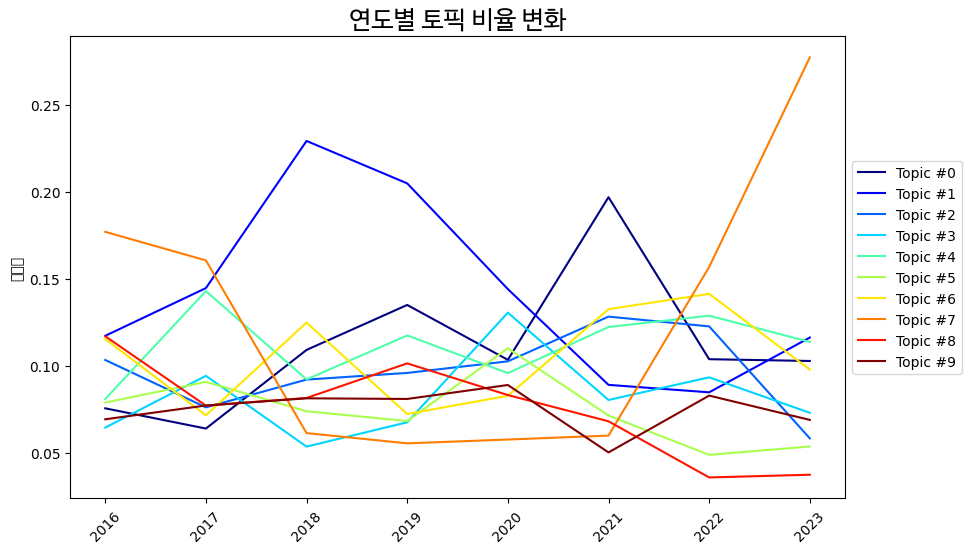

In [45]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.cm as cm
import numpy as np

# 설치된 나눔 폰트 찾기
path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
fontprop = fm.FontProperties(fname=path, size=18)

f = plt.figure(figsize=(10, 6))  # 그래프 크기 조정 (선택 사항)
plt.title('연도별 토픽 비율 변화', color='black', fontproperties=fontprop)

# 빨주노초파남보 색상 설정
colors = cm.get_cmap('jet', topic_dist_by_time.shape[1])  # 토픽 개수에 맞춰 색상 생성

# 각 토픽에 대해 선 그리기
for i in range(topic_dist_by_time.shape[1]):
    plt.plot(topic_dist_by_time.index, topic_dist_by_time.iloc[:, i], color=colors(i), label='Topic #{}'.format(i))

plt.xticks(np.array(range(2016, 2024)), rotation=45)
ax = f.gca()
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.set_ylabel('퍼센트')
plt.show()

<ipython-input-46-4c4f43b1b8bb>:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('jet', topic_dist_by_time.shape[1])  # 토픽 개수에 맞춰 색상 생성


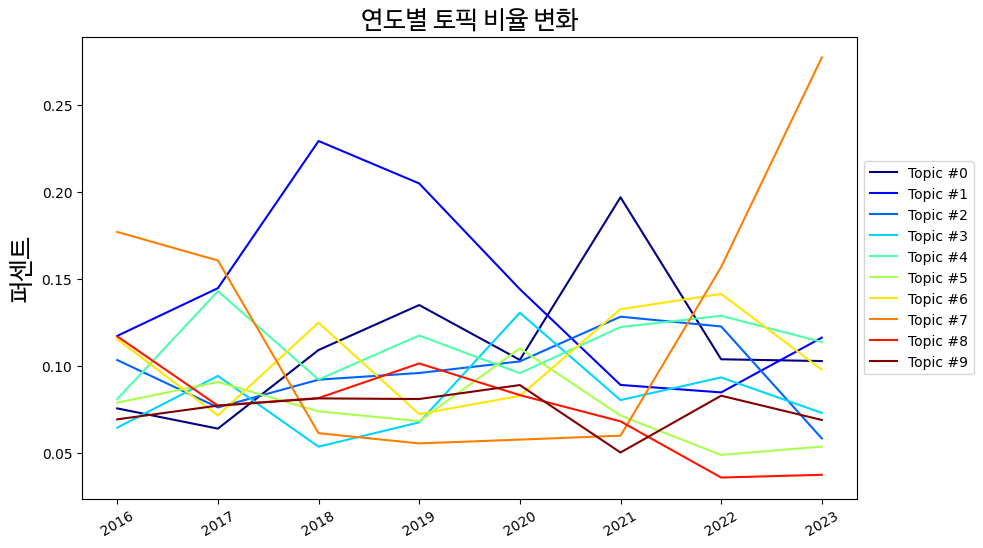

In [46]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.cm as cm
import numpy as np

# 설치된 나눔 폰트 찾기
path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
fontprop = fm.FontProperties(fname=path, size=18)

f = plt.figure(figsize=(10, 6))  # 그래프 크기 조정 (선택 사항)
plt.title('연도별 토픽 비율 변화', color='black', fontproperties=fontprop)

# 빨주노초파남보 색상 설정
colors = cm.get_cmap('jet', topic_dist_by_time.shape[1])  # 토픽 개수에 맞춰 색상 생성

# 각 토픽에 대해 선 그리기
for i in range(topic_dist_by_time.shape[1]):
    plt.plot(topic_dist_by_time.index, topic_dist_by_time.iloc[:, i], color=colors(i), label='Topic #{}'.format(i))

plt.xticks(np.array(range(2016, 2024)), rotation=30)
ax = f.gca()
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
# y축 레이블에 폰트 설정
ax.set_ylabel('퍼센트', fontproperties=fontprop)
plt.show()

- DTM 결과에 대해 대표 기사 추출

In [48]:
def get_topic_distribution_at_timepoint(dtm_model, timepoint):
    """
    특정 시점의 각 문서의 토픽 분포를 가져오는 함수

    Args:
        dtm_model: DTM 모델 객체
        timepoint: 토픽 분포를 가져올 시점 (0부터 시작)

    Returns:
        topic_distribution_df: 특정 시점의 각 문서의 토픽 분포를 담은 DataFrame
    """
    topic_distributions = []
    for doc in dtm_model.docs:
        if doc.timepoint == timepoint:
            topic_dist = doc.get_topic_dist()
            topic_distributions.append(topic_dist)

    topic_distribution_df = pd.DataFrame(topic_distributions)
    return topic_distribution_df

# 예: 시점 0 (첫 번째 시점)의 토픽 분포 가져오기
topic_distribution_df = get_topic_distribution_at_timepoint(DTM, 0)  # DTM 모델 객체와 시점을 입력

In [49]:
def get_top_documents_per_topic(topic_distribution_df, top_n=3):
    """
    각 토픽별로 가장 관련 높은 문서의 인덱스를 가져오는 함수

    Args:
        topic_distribution_df: 각 문서의 토픽 분포를 담은 DataFrame
        top_n: 각 토픽별로 가져올 문서의 개수 (기본값: 3)

    Returns:
        top_documents: 각 토픽별 상위 문서의 인덱스를 담은 딕셔너리
    """
    # ... (LDA와 동일한 코드) ...

top_documents = get_top_documents_per_topic(topic_distribution_df, top_n=3) # top_n 값을 조정하여 원하는 문서 개수를 설정

In [53]:
def get_top_documents_per_topic(topic_distribution_df, top_n=3):
    """
    각 토픽별로 가장 관련 높은 문서의 인덱스를 가져오는 함수

    Args:
        topic_distribution_df: 각 문서의 토픽 분포를 담은 DataFrame
        top_n: 각 토픽별로 가져올 문서의 개수 (기본값: 3)

    Returns:
        top_documents: 각 토픽별 상위 문서의 인덱스를 담은 딕셔너리
    """
    top_documents = {}
    for topic_index in range(topic_distribution_df.shape[1]):
        # 토픽별로 문서 확률을 기준으로 내림차순 정렬
        sorted_documents = topic_distribution_df.iloc[:, topic_index].sort_values(ascending=False)
        # 상위 top_n개 문서의 인덱스 추출
        top_document_indices = sorted_documents.head(top_n).index.tolist()
        # 결과 딕셔너리에 저장
        top_documents[topic_index] = top_document_indices
    return top_documents # This line was missing, causing the function to return None

top_documents = get_top_documents_per_topic(topic_distribution_df, top_n=3) # top_n 값을 조정하여 원하는 문서 개수를 설정

In [54]:
# 각 토픽별 상위 문서 출력
timepoint_document_indices = [doc.timepoint for doc in DTM.docs] # 각 문서의 시점 정보를 가져옵니다.
for topic_index, document_indices in top_documents.items():
    print(f"Topic #{topic_index}:")
    for document_index in document_indices:
        # DTM 문서 인덱스를 원본 데이터 인덱스로 변환
        original_document_index = df.index[timepoint_document_indices.index(0) + document_index] # 시점 정보를 이용하여 원본 데이터 인덱스로 변환합니다.
        print(f"  - Document index: {original_document_index}")
        # 원본 데이터에서 해당 문서의 내용 출력 (예: df.iloc[original_document_index]['내용'])
        print(f"    - Content: {df.iloc[original_document_index]['제목']}")


Topic #0:
  - Document index: 2577
    - Content: 각 시 도에 '문해 교육' 전담 기관 설치된다.
  - Document index: 2593
    - Content: '한국 수화 언어법' 국회 통과 올해 하반기부터 시행
  - Document index: 2561
    - Content: 김범수 카카오 의장, 경기도 스타트업캠퍼스 초대 총장 취임
Topic #1:
  - Document index: 2579
    - Content: [기고] 누구나 미디어로 소통하는 행복한 세상
  - Document index: 2580
    - Content: U어학원 ‘이그잼포유’, 미국 영어교육 기업 ‘Achieve 3000’와 B2C 사업 박차
  - Document index: 2543
    - Content: 방통위,'2016 미디어교육 컨퍼런스' 개최
Topic #2:
  - Document index: 2538
    - Content: 이 와중에  교육부, 초등교과서 한자표기 강행해 거센 반발
  - Document index: 2563
    - Content: 한글전용 위헌여부 12일 공개변론
  - Document index: 2545
    - Content: 예비고1에게 지금 가장 필요한 것!
Topic #3:
  - Document index: 2575
    - Content: 35만 청각장애인 위해 ‘동영상 手語성경’ 만든다
  - Document index: 2590
    - Content: 수화언어, 한국어와 대등한 공용어로 인정
  - Document index: 2536
    - Content: 문제풀이가 느린 학생들
Topic #4:
  - Document index: 2550
    - Content: 디지털 수업, 왜 실패했을까
  - Document index: 2591
    - Content: ‘응팔’ 그 시절 너머... 여공, 꿈을 꾸다
  - Document index: 

- 참고 : 기사량 통계 그래프

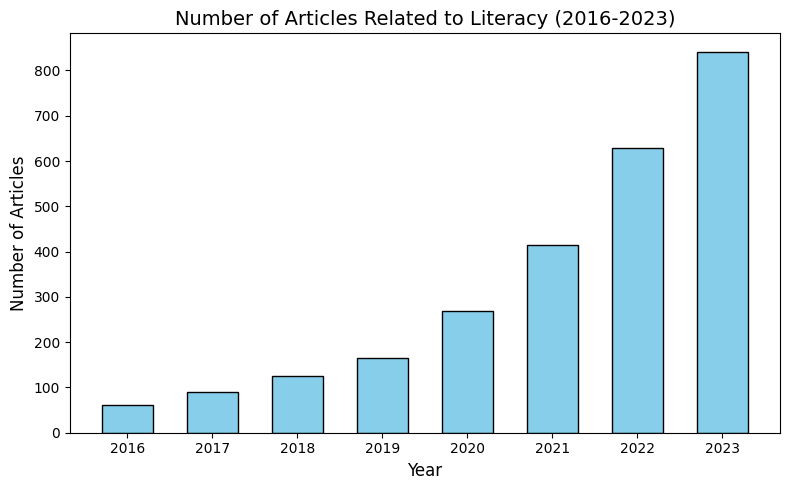

In [47]:
# Re-attempt to create and display the bar chart
import matplotlib.pyplot as plt # plt를 import 합니다.

# Data
years = [2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
article_counts = [62, 89, 125, 165, 269, 415, 629, 840]

# Create the bar chart
plt.figure(figsize=(8, 5))
plt.bar(years, article_counts, color='skyblue', edgecolor='black', width=0.6)

# Labels and title
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Articles', fontsize=12)
plt.title('Number of Articles Related to Literacy (2016-2023)', fontsize=14)
plt.xticks(years, fontsize=10)
plt.yticks(fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()